In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from interaction_inference import dataset, correlation

## Dataset (PNAS Smart-seq-total paper)

Load dataset of single genes

In [2]:
data_FIB = pd.read_csv("./Datasets/GSE151334_FIB_counts_thresh.csv", index_col=0)

### Construct dataset of pairs

In [5]:
# size
genes = 100
gene_pairs = (genes * (genes - 1) // 2) + genes
cells = data_FIB.shape[1]

# construct paired count dataframe
counts_df = pd.DataFrame(
    index = [f"Gene-pair-{i}" for i in range(gene_pairs)],
    columns = [f"Cell-{j}" for j in range(cells)]
)

# fill with pairs
k = 0
for i in range(genes):
    gene_i = data_FIB.iloc[i]
    for j in range(genes):
        if j > i:
            break
        gene_j = data_FIB.iloc[j]
        gene_pair_ij = list(zip(gene_i, gene_j))
        counts_df.iloc[k] = gene_pair_ij
        k += 1

# construct object
dataset_FIB = dataset.Dataset("dataset_FIB")
dataset_FIB.count_dataset = counts_df
dataset_FIB.cells = cells
dataset_FIB.gene_pairs = gene_pairs

### Correlation analysis

In [8]:
correlation_FIB = correlation.Correlation(dataset_FIB, printing=False)

100%|██████████| 5050/5050 [00:18<00:00, 270.32it/s]


In [9]:
pvalue_array = np.zeros((genes, genes))
stat_array = np.zeros((genes, genes))
k = 0
for i in range(genes):
    for j in range(genes):
        # ignore above diagonal
        if j > i:
            pass
        else:
            pvalue_array[i, j] = correlation_FIB.result_dict[k]['pvalue']
            stat_array[i, j] = correlation_FIB.result_dict[k]['statistic']
            k += 1

# fill above diagonal by symmetry
for i in range(genes):
    for j in range(genes):
        if j > i:
            pvalue_array[i, j] = pvalue_array[j, i]
            stat_array[i, j] = stat_array[j, i]

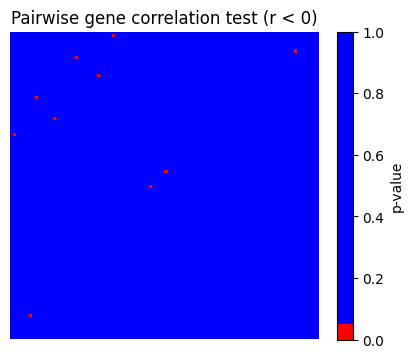

In [10]:
sig_lvl = 0.05
eps = 10**-6

fig, axs = plt.subplots(figsize=(5, 4))
cmap = LinearSegmentedColormap.from_list('br', [(0, "r"), (sig_lvl - eps, "r"), (sig_lvl + eps, "b"), (1, "b")], N=256)
vmin, vmax = 0, 1
img = axs.imshow(pvalue_array, cmap=cmap, vmin=vmin, vmax=vmax)
axs.set_title("Pairwise gene correlation test (r < 0)")
plt.axis('off')
cbar = plt.colorbar(img, ax=axs)
cbar.set_label("p-value")

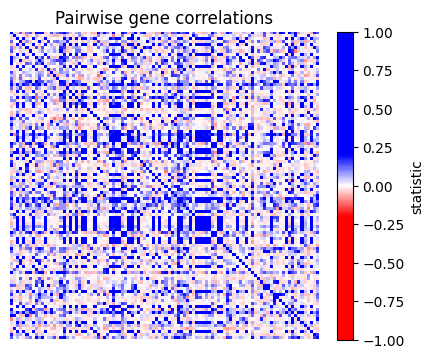

In [43]:
fig, axs = plt.subplots(figsize=(5, 4))
#cmap = LinearSegmentedColormap.from_list('br', [(0, "r"), (-stat_array.min() / (stat_array.max() - stat_array.min()), "w"), (1, "b")], N=256)
cmap = LinearSegmentedColormap.from_list('br', [(0, "r"), (0.4, "r"), (0.5, "w"), (0.6, "b"), (1, "b")], N=256)
vmin, vmax = -1, 1 #stat_array.min(), stat_array.max()
img = axs.imshow(stat_array, cmap=cmap, vmin=vmin, vmax=vmax)
axs.set_title("Pairwise gene correlations")
plt.axis('off')
cbar = plt.colorbar(img, ax=axs)
cbar.set_label("statistic")

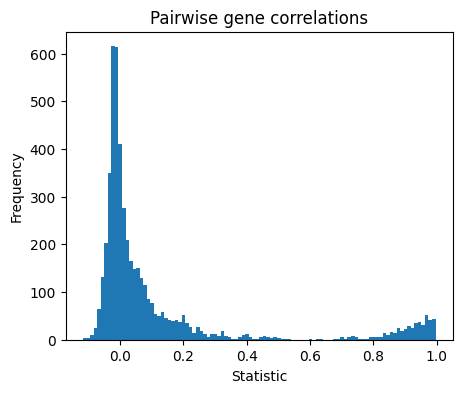

In [12]:
'''
NOTE: Remove repeated correlations due to symmetry (corr(Xi, Xj) = corr(Xj, Xi))
      and correlations between the same gene (corr(Xi, Xi) = 1)
'''
plt.figure(figsize=(5, 4))
plt.hist([x for x in np.tril(stat_array, k=-1).flatten() if x != 0], bins=100);
plt.title("Pairwise gene correlations")
plt.xlabel("Statistic")
plt.ylabel("Frequency")
plt.show()

## BayNorm Datasets

In [3]:
MAP_FIB = pd.read_csv("./Datasets/GSE151334_FIB_counts_MAP.csv", index_col=0)

In [46]:
MEAN_FIB = pd.read_csv("./Datasets/GSE151334_FIB_counts_MAP.csv", index_col=0)

In [4]:
PS_FIB = pd.read_csv("./Datasets/GSE151334_FIB_counts_PS.csv", index_col=0)

In [6]:
# size
genes = 100
gene_pairs = (genes * (genes - 1) // 2) + genes
cells = MAP_FIB.shape[1]

# construct paired count dataframe
counts_df = pd.DataFrame(
    index = [f"Gene-pair-{i}" for i in range(gene_pairs)],
    columns = [f"Cell-{j}" for j in range(cells)]
)

# fill with pairs
k = 0
for i in range(genes):
    gene_i = MAP_FIB.iloc[i]
    for j in range(genes):
        if j > i:
            break
        gene_j = MAP_FIB.iloc[j]
        gene_pair_ij = list(zip(gene_i, gene_j))
        counts_df.iloc[k] = gene_pair_ij
        k += 1

# construct object
dataset_MAP_FIB = dataset.Dataset("dataset_MAP_FIB")
dataset_MAP_FIB.count_dataset = counts_df
dataset_MAP_FIB.cells = cells
dataset_MAP_FIB.gene_pairs = gene_pairs

In [47]:
# size
genes = 100
gene_pairs = (genes * (genes - 1) // 2) + genes
cells = MEAN_FIB.shape[1]

# construct paired count dataframe
counts_df = pd.DataFrame(
    index = [f"Gene-pair-{i}" for i in range(gene_pairs)],
    columns = [f"Cell-{j}" for j in range(cells)]
)

# fill with pairs
k = 0
for i in range(genes):
    gene_i = MEAN_FIB.iloc[i]
    for j in range(genes):
        if j > i:
            break
        gene_j = MEAN_FIB.iloc[j]
        gene_pair_ij = list(zip(gene_i, gene_j))
        counts_df.iloc[k] = gene_pair_ij
        k += 1

# construct object
dataset_MEAN_FIB = dataset.Dataset("dataset_MEAN_FIB")
dataset_MEAN_FIB.count_dataset = counts_df
dataset_MEAN_FIB.cells = cells
dataset_MEAN_FIB.gene_pairs = gene_pairs

In [7]:
# size
genes = 100
gene_pairs = (genes * (genes - 1) // 2) + genes
cells = PS_FIB.shape[1]

# construct paired count dataframe
counts_df = pd.DataFrame(
    index = [f"Gene-pair-{i}" for i in range(gene_pairs)],
    columns = [f"Cell-{j}" for j in range(cells)]
)

# fill with pairs
k = 0
for i in range(genes):
    gene_i = PS_FIB.iloc[i]
    for j in range(genes):
        if j > i:
            break
        gene_j = PS_FIB.iloc[j]
        gene_pair_ij = list(zip(gene_i, gene_j))
        counts_df.iloc[k] = gene_pair_ij
        k += 1

# construct object
dataset_PS_FIB = dataset.Dataset("dataset_PS_FIB")
dataset_PS_FIB.count_dataset = counts_df
dataset_PS_FIB.cells = cells
dataset_PS_FIB.gene_pairs = gene_pairs

In [13]:
correlation_MAP_FIB = correlation.Correlation(dataset_MAP_FIB, printing=False)

100%|██████████| 5050/5050 [00:11<00:00, 433.14it/s]


In [48]:
correlation_MEAN_FIB = correlation.Correlation(dataset_MEAN_FIB, printing=False)

100%|██████████| 5050/5050 [00:07<00:00, 688.91it/s]


In [14]:
correlation_PS_FIB = correlation.Correlation(dataset_PS_FIB, printing=False)

100%|██████████| 5050/5050 [00:47<00:00, 105.29it/s]


In [49]:
MAP_pvalue_array = np.zeros((genes, genes))
MAP_stat_array = np.zeros((genes, genes))
MEAN_pvalue_array = np.zeros((genes, genes))
MEAN_stat_array = np.zeros((genes, genes))
PS_pvalue_array = np.zeros((genes, genes))
PS_stat_array = np.zeros((genes, genes))
k = 0
for i in range(genes):
    for j in range(genes):
        # ignore above diagonal
        if j > i:
            pass
        else:
            MAP_pvalue_array[i, j] = correlation_MAP_FIB.result_dict[k]['pvalue']
            MAP_stat_array[i, j] = correlation_MAP_FIB.result_dict[k]['statistic']
            MEAN_pvalue_array[i, j] = correlation_MEAN_FIB.result_dict[k]['pvalue']
            MEAN_stat_array[i, j] = correlation_MEAN_FIB.result_dict[k]['statistic']
            PS_pvalue_array[i, j] = correlation_PS_FIB.result_dict[k]['pvalue']
            PS_stat_array[i, j] = correlation_PS_FIB.result_dict[k]['statistic']
            k += 1

# fill above diagonal by symmetry
for i in range(genes):
    for j in range(genes):
        if j > i:
            MAP_pvalue_array[i, j] = MAP_pvalue_array[j, i]
            MAP_stat_array[i, j] = MAP_stat_array[j, i]
            MEAN_pvalue_array[i, j] = MEAN_pvalue_array[j, i]
            MEAN_stat_array[i, j] = MEAN_stat_array[j, i]
            PS_pvalue_array[i, j] = PS_pvalue_array[j, i]
            PS_stat_array[i, j] = PS_stat_array[j, i]

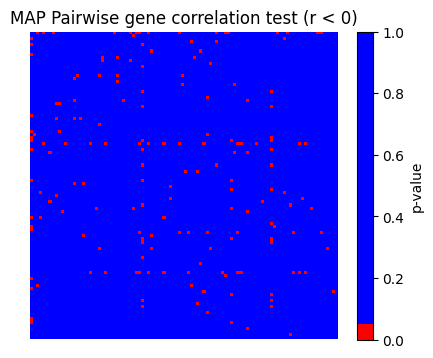

In [16]:
sig_lvl = 0.05
eps = 10**-6

fig, axs = plt.subplots(figsize=(5, 4))
cmap = LinearSegmentedColormap.from_list('br', [(0, "r"), (sig_lvl - eps, "r"), (sig_lvl + eps, "b"), (1, "b")], N=256)
vmin, vmax = 0, 1
img = axs.imshow(MAP_pvalue_array, cmap=cmap, vmin=vmin, vmax=vmax)
axs.set_title("MAP Pairwise gene correlation test (r < 0)")
plt.axis('off')
cbar = plt.colorbar(img, ax=axs)
cbar.set_label("p-value")

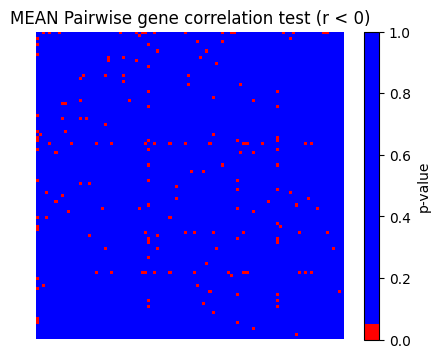

In [50]:
sig_lvl = 0.05
eps = 10**-6

fig, axs = plt.subplots(figsize=(5, 4))
cmap = LinearSegmentedColormap.from_list('br', [(0, "r"), (sig_lvl - eps, "r"), (sig_lvl + eps, "b"), (1, "b")], N=256)
vmin, vmax = 0, 1
img = axs.imshow(MEAN_pvalue_array, cmap=cmap, vmin=vmin, vmax=vmax)
axs.set_title("MEAN Pairwise gene correlation test (r < 0)")
plt.axis('off')
cbar = plt.colorbar(img, ax=axs)
cbar.set_label("p-value")

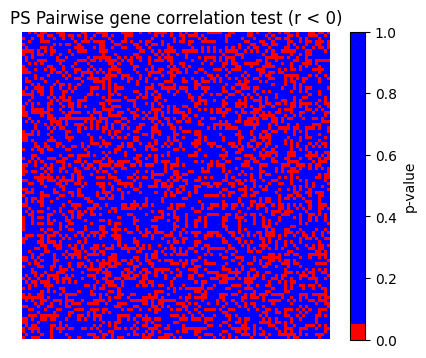

In [18]:
sig_lvl = 0.05
eps = 10**-6

fig, axs = plt.subplots(figsize=(5, 4))
cmap = LinearSegmentedColormap.from_list('br', [(0, "r"), (sig_lvl - eps, "r"), (sig_lvl + eps, "b"), (1, "b")], N=256)
vmin, vmax = 0, 1
img = axs.imshow(PS_pvalue_array, cmap=cmap, vmin=vmin, vmax=vmax)
axs.set_title("PS Pairwise gene correlation test (r < 0)")
plt.axis('off')
cbar = plt.colorbar(img, ax=axs)
cbar.set_label("p-value")

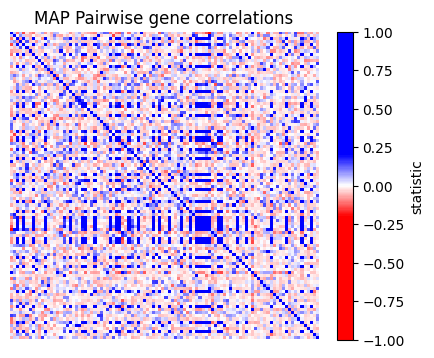

In [45]:
fig, axs = plt.subplots(figsize=(5, 4))
#cmap = LinearSegmentedColormap.from_list('br', [(0, "r"), (-MAP_stat_array.min() / (MAP_stat_array.max() - MAP_stat_array.min()), "w"), (1, "b")], N=256)
cmap = LinearSegmentedColormap.from_list('br', [(0, "r"), (0.4, "r"), (0.5, "w"), (0.6, "b"), (1, "b")], N=256)
vmin, vmax = -1, 1 #MAP_stat_array.min(), MAP_stat_array.max()
img = axs.imshow(MAP_stat_array, cmap=cmap, vmin=vmin, vmax=vmax)
axs.set_title("MAP Pairwise gene correlations")
plt.axis('off')
cbar = plt.colorbar(img, ax=axs)
cbar.set_label("statistic")

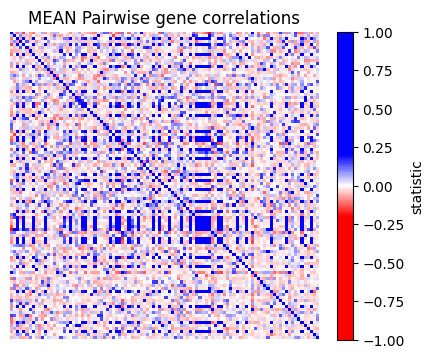

In [51]:
fig, axs = plt.subplots(figsize=(5, 4))
#cmap = LinearSegmentedColormap.from_list('br', [(0, "r"), (-MEAN_stat_array.min() / (MEAN_stat_array.max() - MEAN_stat_array.min()), "w"), (1, "b")], N=256)
cmap = LinearSegmentedColormap.from_list('br', [(0, "r"), (0.4, "r"), (0.5, "w"), (0.6, "b"), (1, "b")], N=256)
vmin, vmax = -1, 1 #MEAN_stat_array.min(), MEAN_stat_array.max()
img = axs.imshow(MEAN_stat_array, cmap=cmap, vmin=vmin, vmax=vmax)
axs.set_title("MEAN Pairwise gene correlations")
plt.axis('off')
cbar = plt.colorbar(img, ax=axs)
cbar.set_label("statistic")

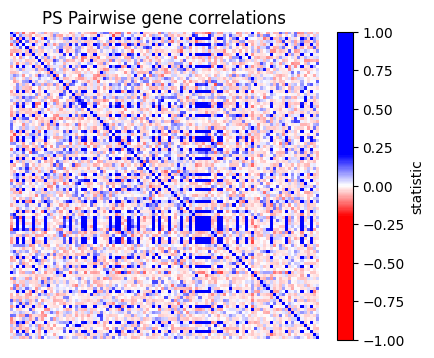

In [38]:
fig, axs = plt.subplots(figsize=(5, 4))
#cmap = LinearSegmentedColormap.from_list('br', [(0, "r"), (-PS_stat_array.min() / (PS_stat_array.max() - PS_stat_array.min()), "w"), (1, "b")], N=256)
cmap = LinearSegmentedColormap.from_list('br', [(0, "r"), (0.4, "r"), (0.5, "w"), (0.6, "b"), (1, "b")], N=256)
vmin, vmax = -1, 1 #PS_stat_array.min(), PS_stat_array.max()
img = axs.imshow(PS_stat_array, cmap=cmap, vmin=vmin, vmax=vmax)
axs.set_title("PS Pairwise gene correlations")
plt.axis('off')
cbar = plt.colorbar(img, ax=axs)
cbar.set_label("statistic")

Text(0.5, 1.0, "Pairwise correlations of samples \nfor observed and BayNorm 'upscaled' datasets")

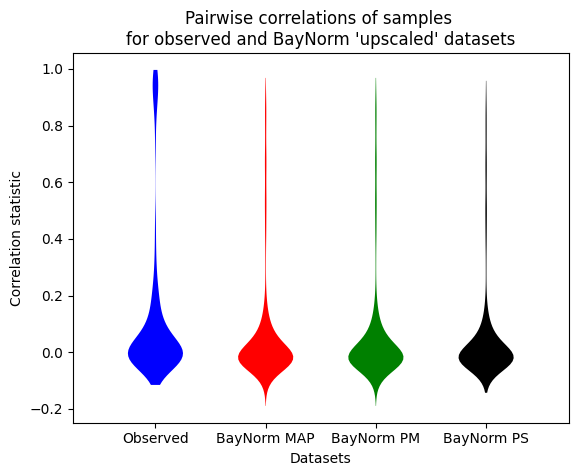

In [84]:
fig, axs = plt.subplots()
vp = axs.violinplot(
    [
        [x for x in np.tril(stat_array, k=-1).flatten() if x != 0],
        [x for x in np.tril(MAP_stat_array, k=-1).flatten() if x != 0],
        [x for x in np.tril(MEAN_stat_array, k=-1).flatten() if x != 0],
        [x for x in np.tril(PS_stat_array, k=-1).flatten() if x != 0],
    ],
    showextrema=False
)
colours = ["blue", "red", "green", "black"]
for i, vi in enumerate(vp['bodies']):
    vi.set_facecolor(colours[i])
    vi.set_edgecolor(None)
    vi.set_alpha(1)
labels = ["Observed", "BayNorm MAP", "BayNorm PM", "BayNorm PS"]
axs.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
axs.set_xlim(0.25, len(labels) + 0.75)
axs.set_xlabel('Datasets')
axs.set_ylabel("Correlation statistic")
axs.set_title("Pairwise correlations of samples \nfor observed and BayNorm 'upscaled' datasets")

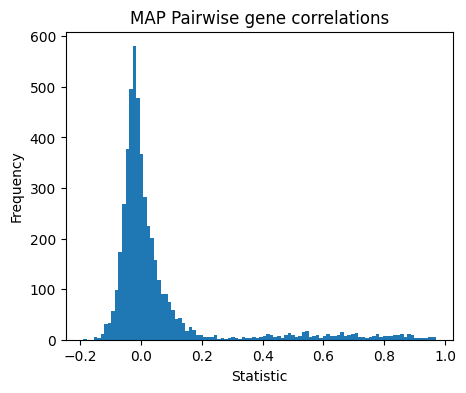

In [85]:
'''
NOTE: Remove repeated correlations due to symmetry (corr(Xi, Xj) = corr(Xj, Xi))
      and correlations between the same gene (corr(Xi, Xi) = 1)
'''
plt.figure(figsize=(5, 4))
plt.hist([x for x in np.tril(MAP_stat_array, k=-1).flatten() if x != 0], bins=100);
plt.title("MAP Pairwise gene correlations")
plt.xlabel("Statistic")
plt.ylabel("Frequency")
plt.show()

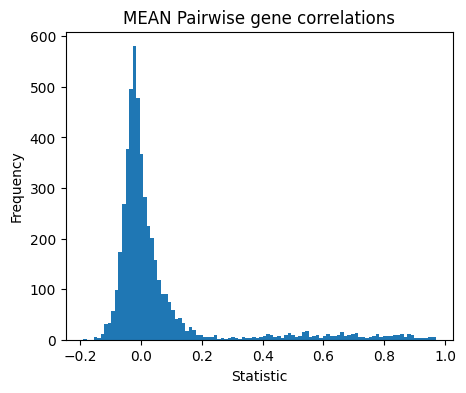

In [52]:
'''
NOTE: Remove repeated correlations due to symmetry (corr(Xi, Xj) = corr(Xj, Xi))
      and correlations between the same gene (corr(Xi, Xi) = 1)
'''
plt.figure(figsize=(5, 4))
plt.hist([x for x in np.tril(MEAN_stat_array, k=-1).flatten() if x != 0], bins=100);
plt.title("MEAN Pairwise gene correlations")
plt.xlabel("Statistic")
plt.ylabel("Frequency")
plt.show()

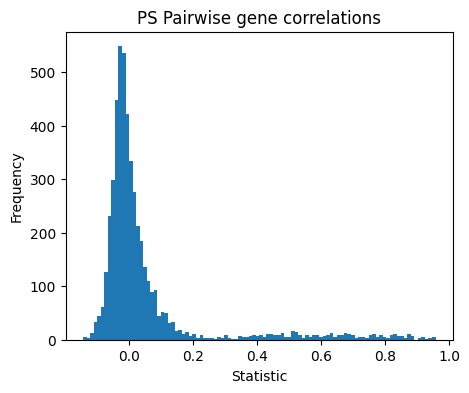

In [27]:
'''
NOTE: Remove repeated correlations due to symmetry (corr(Xi, Xj) = corr(Xj, Xi))
      and correlations between the same gene (corr(Xi, Xi) = 1)
'''
plt.figure(figsize=(5, 4))
plt.hist([x for x in np.tril(PS_stat_array, k=-1).flatten() if x != 0], bins=100);
plt.title("PS Pairwise gene correlations")
plt.xlabel("Statistic")
plt.ylabel("Frequency")
plt.show()

## Sankey plots

In [89]:
import plotly
import plotly.graph_objects as go
import pandas as pd

In [124]:
def sankey_from_df(df):

    column_number = df.shape[1]

    # unique values per column
    column_values = []

    # box indices per column
    column_indices = []

    i = 1
    for col in df.columns:

        values = df[col].unique().tolist()
        column_values.append(values)

        boxes = len(values)
        indices = [x for x in range(i, i + boxes)]
        column_indices.append(indices)

        i += boxes

    # plotting
    source = []
    target = []
    count = []

    # special case for first gap

    # end values
    val_end = column_values[0]

    # end indices
    idx_end = column_indices[0]

    # end column
    col_end = df[df.columns[0]]

    # for each end value
    for val_k, idx_k in zip(val_end, idx_end):

        # get count
        count_k = len(df.loc[col_end == val_k])

        # add link to plot: from 0 to idx with size count
        source.append(0)
        target.append(idx_k)
        count.append(count_k)

    for i in range(column_number - 1):

        # get values
        val_start = column_values[i]
        val_end = column_values[i + 1]

        # get indices
        idx_start = column_indices[i]
        idx_end = column_indices[i + 1]

        # get columns
        col_start = df[df.columns[i]]
        col_end = df[df.columns[i + 1]]

        # for each pair of values level
        for val_j, idx_j in zip(val_start, idx_start):
            for val_k, idx_k in zip(val_end, idx_end):

                # get overlap
                count_jk = len(df.loc[(col_start == val_j) & (col_end == val_k)])

                # add link to plot: from idx_j to idx_k with size count_jk
                source.append(idx_j)
                target.append(idx_k)
                count.append(count_jk)

    # box labels
    labels = [""]
    for values in column_values:
        for val in values:
            labels.append(str(val))

    fig = go.Figure(data=[go.Sankey(
        node = {"label": labels},
        link = {"source": source, "target": target, "value": count, "color": "lightgrey"}
        )])

    headers = ["Gene pairs"] + list(df.columns)
    for x_coordinate, column_name in enumerate(headers):
        fig.add_annotation(
                x=x_coordinate / (column_number),
                y=1.1,
                xref="paper",
                yref="paper",
                text=column_name,
                showarrow=False,
                font=dict(
                    family="Courier New, monospace",
                    size=16,
                    color="tomato"
                    ),
                align="center",
                )
        
    #fig.update_layout(font_size=15)
    fig.update_layout(
        title_text="Basic Sankey Diagram", 
        xaxis={
        'showgrid': False, # thin lines in the background
        'zeroline': False, # thick line at x=0
        'visible': False,  # numbers below
        },
        yaxis={
        'showgrid': False, # thin lines in the background
        'zeroline': False, # thick line at x=0
        'visible': False,  # numbers below
        }, plot_bgcolor='rgba(0,0,0,0)', font_size=10
    )

    fig.show()

In [125]:
def result_to_list(result, sig=0.05):
    result_list = []
    for corr in result.result_dict.values():
        if corr['pvalue'] < sig:
            result_list.append("Interaction")
        else:
            result_list.append("Independent")
    return result_list

In [132]:
corr_df = pd.DataFrame()
corr_df["OB Correlations"] = result_to_list(correlation_FIB)
corr_df["MAP Correlations"] = result_to_list(correlation_MAP_FIB)
corr_df["PM correlations"] = result_to_list(correlation_MEAN_FIB)
corr_df["PS correlations"] = result_to_list(correlation_PS_FIB)

In [133]:
sankey_from_df(corr_df)